In [1]:
import warnings

import numpy as np
import pandas as pd
from matplotlib import pylab as plt

import sklearn
sklearn.set_config(enable_metadata_routing=True)

from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.subsample import BlockBootstrap
from mapie.regression import MapieTimeSeriesRegressor, MapieRegressor

warnings.simplefilter("ignore")

In [2]:

cv = BlockBootstrap(n_resamplings=10, n_blocks=5, random_state=59)
X = np.array([i for i in range(10)])
for train_index, test_index in cv.split(X):
   print(f"train index is {train_index}, test index is {test_index}")
   print(f"test index is {test_index}")

train index is [2 3 8 9 6 7 2 3 0 1], test index is [4 5]
test index is [4 5]
train index is [6 7 0 1 6 7 2 3 0 1], test index is [8 9 4 5]
test index is [8 9 4 5]
train index is [2 3 8 9 4 5 2 3 6 7], test index is [0 1]
test index is [0 1]
train index is [4 5 4 5 4 5 8 9 2 3], test index is [0 1 6 7]
test index is [0 1 6 7]
train index is [4 5 0 1 2 3 4 5 0 1], test index is [8 9 6 7]
test index is [8 9 6 7]
train index is [8 9 8 9 2 3 6 7 2 3], test index is [0 1 4 5]
test index is [0 1 4 5]
train index is [4 5 0 1 8 9 4 5 2 3], test index is [6 7]
test index is [6 7]
train index is [6 7 4 5 8 9 6 7 2 3], test index is [0 1]
test index is [0 1]
train index is [8 9 2 3 8 9 0 1 2 3], test index is [4 5 6 7]
test index is [4 5 6 7]
train index is [0 1 8 9 8 9 0 1 6 7], test index is [2 3 4 5]
test index is [2 3 4 5]


In [6]:
import sys
sys.path.append(r'C:\Users\obhlivoj\DP\System-Imbalance-Forecasting\models\xgboost')

import torch
import json

from config import get_config
from train import get_ds, get_model

path = r'C:\Users\obhlivoj\DP\System-Imbalance-Forecasting\models\xgboost'

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = get_config()

# read json_info
with open(f'{path}\params.json', 'r') as file:
    best_params = json.load(file)

for param, value in best_params['best_params'][0].items():
    cfg[param] = value

cfg['early_stopping_rounds'] = None
cfg['n_estimators'] = 10

model = get_model(cfg, device)
# Load the pretrained weights
model.load_model(f"{path}/weights_folder/weightsforward_1/xgb_model_1.json")

# config updates
cfg['run'] = f"mapie_test"
cfg['model_folder'] += cfg['run']

train, val, test = get_ds(cfg)
x_train, y_train, hist_train = train
x_val, y_val, hist_val = val
x_test, y_test, hist_test = test

In [9]:
cv_mapiets = BlockBootstrap(
    n_resamplings=4, n_blocks=10, overlapping=False, random_state=69
)

In [10]:
from mapie.conformity_scores import AbsoluteConformityScore

my_conformity_score = AbsoluteConformityScore()
my_conformity_score.consistency_check = False

alpha = 0.05

# https://github.com/scikit-learn-contrib/MAPIE/issues/321

# mapie_ts = MapieTimeSeriesRegressor(
#     model, method="enbpi", cv="prefit", agg_function="mean", n_jobs=-1
# )
mapie_model = MapieRegressor(
    model, cv = "prefit", n_jobs=-1, conformity_score=my_conformity_score
)

In [11]:
mapie_model.fit(x_val, y_val)

MapieRegressor(conformity_score=<mapie.conformity_scores.residual_conformity_scores.AbsoluteConformityScore object at 0x0000023552165C60>,
               cv='prefit',
               estimator=XGBRegressor(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device='cuda',
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eva...
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=0.06, max_bin=None,
                                      max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=4,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=10,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
               method='base', n_jobs=-1)

In [46]:
y_pred, y_pis = mapie_model.predict(x_test, alpha=alpha)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

In [41]:
width

466.6939697265625

In [47]:
y_pis[0:10].squeeze()

array([[-235.79165459,  230.90231514],
       [ -27.65193176,  439.04203796],
       [-127.8177948 ,  338.87617493],
       [-213.98116875,  252.71280098],
       [-177.67537689,  289.01859283],
       [-185.95734787,  280.73662186],
       [-173.09521484,  293.59875488],
       [-282.61875153,  184.0752182 ],
       [-203.52150917,  263.17246056],
       [-223.62475109,  243.06921864]])

In [28]:
from sklearn.metrics import mean_squared_error

mean_squared_error(mapie_model.predict(x_test), y_test, squared=False)


110.51712

In [55]:
x_calib = np.concatenate((x_train, x_val), axis = 0)
y_calib = np.concatenate((y_train, y_val), axis = 0)

cfg['n_estimators'] = 100
model = get_model(cfg, device)

mapie_ts = MapieTimeSeriesRegressor(
    model, method="enbpi", cv=cv_mapiets, agg_function="mean", n_jobs=-1
)

mapie_ts.fit(x_calib, y_calib.squeeze(-1))

In [50]:
y_pred, y_pis = mapie_ts.predict(x_test, alpha=alpha)
coverage = regression_coverage_score(y_test, y_pis[:, 0, 0], y_pis[:, 1, 0])
width = regression_mean_width_score(y_pis[:, 0, 0], y_pis[:, 1, 0])

In [52]:
mean_squared_error(mapie_ts.predict(x_test), y_test, squared=False)

111.867256

In [51]:
width

482.8836218516032

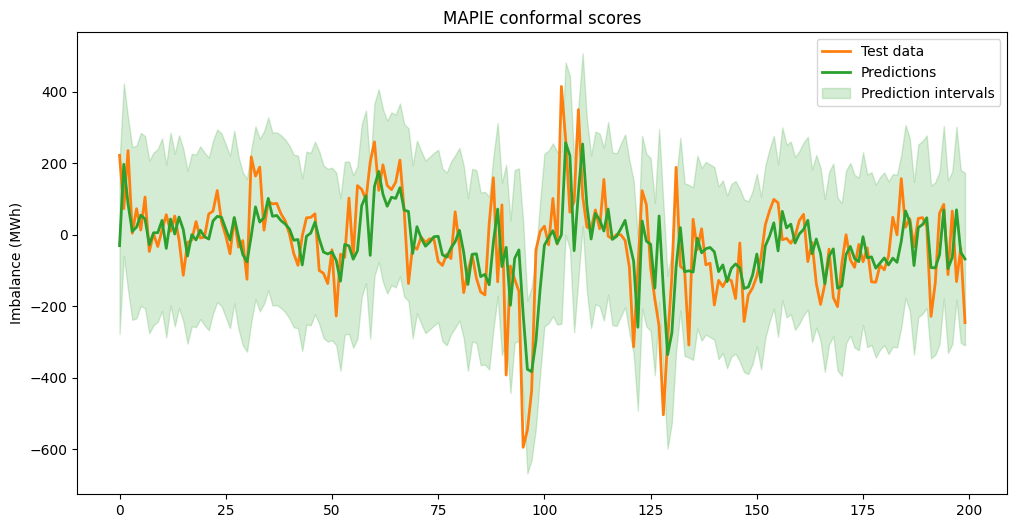

In [38]:
start, end = 0, 200
test_range = [i for i in range(start, end)]

plt.figure(figsize=(12, 6), dpi=100)

plt.plot(test_range, y_test[start:end], lw=2, label="Test data", c="C1")
plt.plot(test_range, y_pred[start:end], lw=2, c="C2", label="Predictions")
plt.ylabel("Imbalance (MWh)")

plt.fill_between(
    test_range,
    y_pis[start:end][:, 0, 0],
    y_pis[start:end][:, 1, 0],
    color="C2",
    alpha=0.2,
    label="Prediction intervals",
)
plt.title("MAPIE conformal scores")
plt.legend()
plt.show()


In [112]:
y_test[0:8]

array([[221.701],
       [ 72.366],
       [234.895],
       [  3.753],
       [ 72.379],
       [ 12.685],
       [104.991],
       [-47.274]], dtype=float32)

In [110]:
y_pred[0:8]

array([ -3.601606, 204.58592 , 104.66925 ,  18.50588 ,  55.606316,
        47.57355 ,  59.63542 , -49.38874 ], dtype=float32)

In [111]:
y_pis[0:8].squeeze()

array([[-158.35876226,  151.15555048],
       [  49.82876587,  359.34307861],
       [ -50.08790588,  259.42640686],
       [-136.25127602,  173.26303673],
       [ -99.15084076,  210.36347198],
       [-107.18360519,  202.33070755],
       [ -95.12173462,  214.39257812],
       [-204.14589691,  105.36841583]])

In [120]:
coverage

0.8656580593789103

In [119]:
width

309.5143127441406

In [46]:
# full fit
alpha = 0.05
y_pred_npfit, y_pis_npfit = mapie_model.predict(
    x_test, alpha=alpha, ensemble=True, optimize_beta=True
)
coverage_npfit = regression_coverage_score(
    y_test, y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)
width_npfit = regression_mean_width_score(
    y_pis_npfit[:, 0, 0], y_pis_npfit[:, 1, 0]
)

In [81]:
y_pred_npfit, y_pis_npfit = mapie_enbpi.predict(
    x_test, alpha=alpha, ensemble=True, optimize_beta=True
)

In [57]:
# partial fit
gap = 1
mapie_enbpi = mapie_ts.fit(x_calib, y_calib.squeeze())

y_pred_pfit = np.zeros(y_pred.shape)
y_pis_pfit = np.zeros(y_pis.shape)
conformity_scores_pfit = []
lower_quantiles_pfit = []
higher_quantiles_pfit = []
y_pred_pfit[:gap], y_pis_pfit[:gap, :, :] = mapie_enbpi.predict(
    x_test[:gap, :], alpha=alpha, ensemble=True, optimize_beta=True
)
for step in range(gap, len(x_test), gap):
    mapie_enbpi.partial_fit(
        x_test[(step - gap):step, :],
        y_test[(step - gap):step],
    )
    (
        y_pred_pfit[step:step + gap],
        y_pis_pfit[step:step + gap, :, :],
    ) = mapie_enbpi.predict(
        x_test[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    conformity_scores_pfit.append(mapie_enbpi.conformity_scores_)
    lower_quantiles_pfit.append(mapie_enbpi.lower_quantiles_)
    higher_quantiles_pfit.append(mapie_enbpi.higher_quantiles_)
coverage_pfit = regression_coverage_score(
    y_test, y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)
width_pfit = regression_mean_width_score(
    y_pis_pfit[:, 0, 0], y_pis_pfit[:, 1, 0]
)

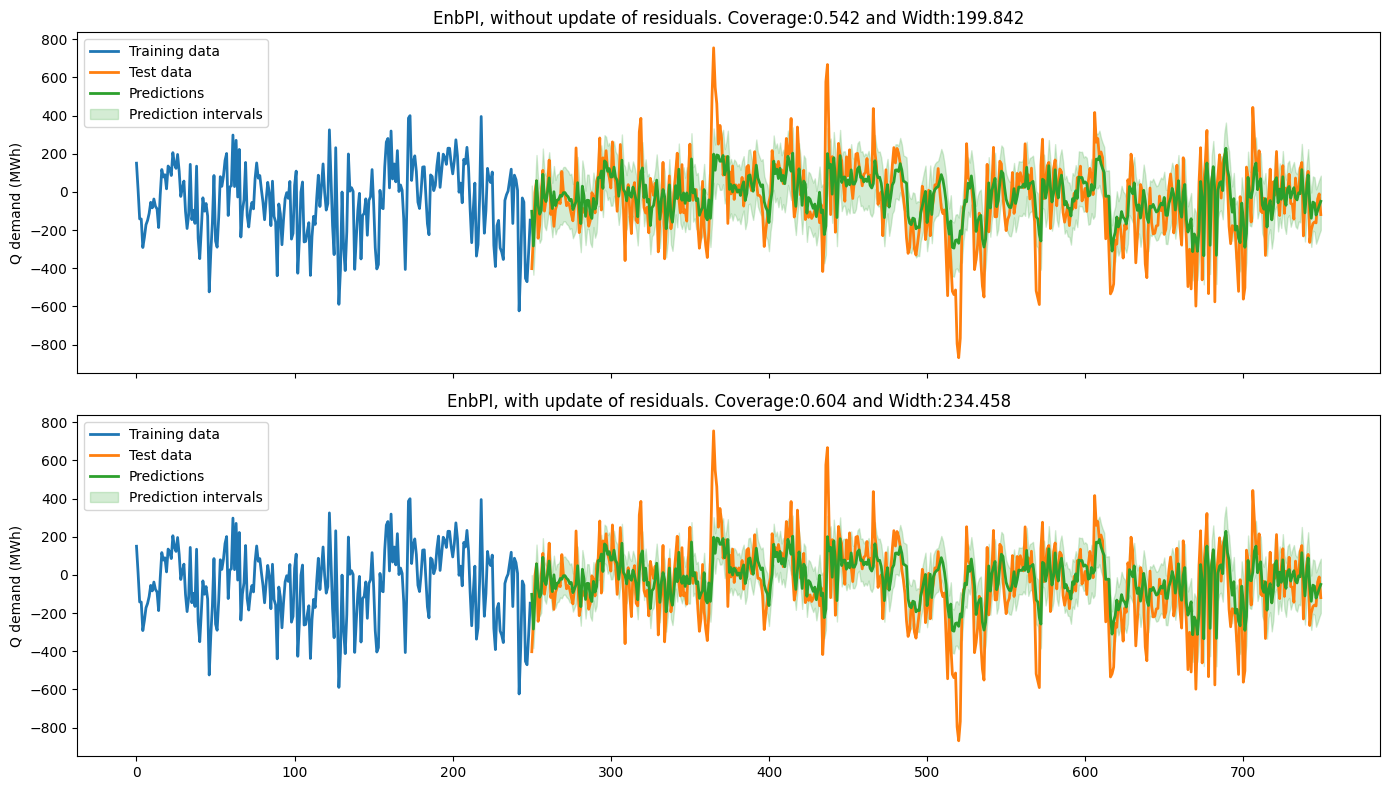

In [95]:
y_preds = [y_pred_npfit, y_pred_pfit]
y_pis = [y_pis_npfit, y_pis_pfit]
coverages = [coverage_npfit, coverage_pfit]
widths = [width_npfit, width_pfit]

index_split = int(len(y_test)/2)
test_range = [i for i in range(index_split, index_split+len(y_test))]

fig, axs = plt.subplots(
    nrows=2, ncols=1, figsize=(14, 8), sharey="row", sharex="col"
)
for i, (ax, w) in enumerate(zip(axs, ["without", "with"])):
    ax.set_ylabel("Q demand (MWh)")
    ax.plot(
        y_train[-index_split:],
        lw=2,
        label="Training data", c="C0"
    )
    ax.plot(test_range, y_test, lw=2, label="Test data", c="C1")

    ax.plot(
        test_range, y_preds[i], lw=2, c="C2", label="Predictions"
    )
    ax.fill_between(
        test_range,
        y_pis[i][:, 0, 0],
        y_pis[i][:, 1, 0],
        color="C2",
        alpha=0.2,
        label="Prediction intervals",
    )
    title = f"EnbPI, {w} update of residuals. "
    title += f"Coverage:{coverages[i]:.3f} and Width:{widths[i]:.3f}"
    ax.set_title(title)
    ax.legend()
fig.tight_layout()
plt.show()

In [ ]:
# TODO:
# ! trenovaci parametry nelze pouzit, napr. early_stopping, jelikoz nelze dodat eval_set
# - rozmyslet CV, jelikož pro bootstrap nemůžu využít evaluaci pro časové řady
# - udelat pro 8 modelu
# - pridat moznost pro modely z torche, navid na githubu v issues
#   https://github.com/scikit-learn-contrib/MAPIE/issues/340